In [35]:
import pandas as pd
import numpy as np
import tensorflow as tf
import numpy.linalg as LA
from copy import deepcopy
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = './nomad2018-predict-transparent-conductors'

def custom_converter(entry):
    return np.array([float(x) for x in entry[1:-1].split(',')])

train_all_data = pd.read_csv(
    f'{DATA_PATH}/train_extrainfo.csv',
    converters={
        'CoulombMatrix':custom_converter,
        'SineMatrix':custom_converter,
        'EwaldSumMatrix':custom_converter
    }
)
test_all_data = pd.read_csv(
    f'{DATA_PATH}/test_extrainfo.csv',
    converters={
        'CoulombMatrix':custom_converter,
        'SineMatrix':custom_converter,
        'EwaldSumMatrix':custom_converter
    }
)

In [18]:
train_all_data.columns

Index(['id', 'spacegroup', 'number_of_total_atoms', 'percent_atom_al',
       'percent_atom_ga', 'percent_atom_in', 'lattice_vector_1_ang',
       'lattice_vector_2_ang', 'lattice_vector_3_ang',
       'lattice_angle_alpha_degree', 'lattice_angle_beta_degree',
       'lattice_angle_gamma_degree', 'formation_energy_ev_natom',
       'bandgap_energy_ev', 'CoulombMatrix', 'SineMatrix', 'EwaldSumMatrix'],
      dtype='object')

In [59]:

def get_eigenspectrum(matrix):
    spectrum = LA.eigvalsh(matrix)
    spectrum = np.sort(spectrum)[::-1]
    return spectrum

def preprocess(data, train=True):
    data = deepcopy(data)
    spectrum_list = []
    for m in data['SineMatrix']:
        spectrum_list.append(
            get_eigenspectrum(
                np.reshape(m, (80, 80))
            )
        )
    spectrum_df = pd.DataFrame(spectrum_list).astype(float)
    if train:
        to_drop = ['id', 'formation_energy_ev_natom', 'bandgap_energy_ev',
                'CoulombMatrix', 'SineMatrix', 'EwaldSumMatrix']
    else:
        to_drop = ['id',
               'CoulombMatrix', 'SineMatrix', 'EwaldSumMatrix']
    dfcombined = pd.concat([data, spectrum_df], axis=1).drop(to_drop, axis=1)
    return dfcombined


In [25]:
target_cols = ['formation_energy_ev_natom','bandgap_energy_ev']
data = preprocess(train_all_data)

X_train, X_test, y_train, y_test = train_test_split(data, train_all_data[target_cols], test_size = 0.30, random_state=1)


In [26]:
X_train

,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,...,70,71,72,73,74,75,76,77,78,79
60,206,80.0,0.0938,0.6875,0.2188,9.5583,9.5583,9.5580,90.0045,90.0040,...,51.278905,51.192050,50.684798,50.255256,49.243095,48.444891,48.437744,47.624117,41.435008,39.785544
2079,206,80.0,0.4062,0.2500,0.3438,9.5382,9.5379,9.5380,90.0024,90.0027,...,48.124473,47.073484,46.151431,44.098866,41.950107,40.599060,39.816876,38.936680,37.261905,34.584100
1395,33,40.0,0.0000,0.6250,0.3750,5.3302,9.1151,9.7342,89.9979,89.9997,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2227,33,80.0,0.0000,0.3125,0.6875,11.0070,9.3773,9.9993,89.9990,89.9976,...,53.141250,52.234727,52.214577,51.469821,51.383424,50.551757,47.950949,47.940750,47.005041,45.728682
701,206,80.0,0.7500,0.2500,0.0000,9.0894,9.0888,9.0890,90.0034,90.0041,...,38.356714,37.568985,36.881481,35.529089,34.133708,33.929112,31.491647,31.410154,30.403501,23.782710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,167,30.0,0.0000,0.1667,0.8333,5.4918,5.4913,14.5600,89.9984,89.9993,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
905,33,80.0,0.3438,0.0312,0.6250,10.7770,9.1878,9.8151,90.0022,89.9990,...,51.358700,50.391844,49.539896,49.029609,48.132958,47.697284,46.699077,46.315230,46.134322,42.784553
1096,12,80.0,0.5000,0.1875,0.3125,24.3195,6.2018,6.0952,89.9996,104.7008,...,40.919317,40.599176,38.824526,36.662027,35.667331,32.352772,29.573998,25.913214,24.889890,23.723443
235,167,30.0,0.4167,0.0833,0.5000,5.2158,5.2154,13.9784,89.9940,90.0058,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [27]:
X_train.to_numpy().shape

(1680, 91)

In [78]:
model = models.Sequential([
    layers.Dense(91, activation='relu'),
    layers.Dense(80, activation='relu'),
    layers.Dense(60, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(2),
])
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.MeanSquaredError(),
    metrics=['accuracy']
)

In [79]:
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test))

Epoch 1/150
53/53 [==============================] - 1s 4ms/step - loss: 29971.1191 - accuracy: 0.6595 - val_loss: 234.2601 - val_accuracy: 0.6125
Epoch 2/150
53/53 [==============================] - 0s 2ms/step - loss: 160.4642 - accuracy: 0.6042 - val_loss: 100.8353 - val_accuracy: 0.6542
Epoch 3/150
53/53 [==============================] - 0s 2ms/step - loss: 79.9374 - accuracy: 0.6524 - val_loss: 61.1912 - val_accuracy: 0.5958
Epoch 4/150
53/53 [==============================] - 0s 2ms/step - loss: 50.6903 - accuracy: 0.6619 - val_loss: 41.7212 - val_accuracy: 0.6139
Epoch 5/150
53/53 [==============================] - 0s 2ms/step - loss: 35.8222 - accuracy: 0.6315 - val_loss: 33.8334 - val_accuracy: 0.6153
Epoch 6/150
53/53 [==============================] - 0s 2ms/step - loss: 28.6661 - accuracy: 0.6321 - val_loss: 27.3570 - val_accuracy: 0.6278
Epoch 7/150
53/53 [==============================] - 0s 2ms/step - loss: 24.2335 - accuracy: 0.6417 - val_loss: 23.4671 - val_accuracy: 

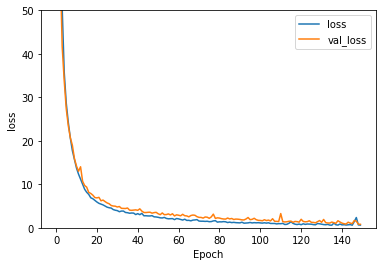

In [80]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 50])
plt.legend(loc='upper right')


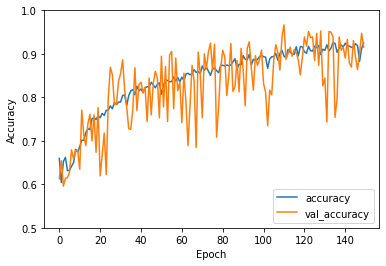

In [82]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


## Create submission

In [83]:
test_output = model(preprocess(test_all_data, train=False).to_numpy())

In [84]:
test_output

<tf.Tensor: shape=(600, 2), dtype=float32, numpy=
array([[ 0.6968099 , -0.15645929],
       [ 0.1811408 ,  3.7213125 ],
       [ 0.23502935,  2.5208182 ],
       ...,
       [ 1.2462045 ,  1.6871037 ],
       [ 0.22445406,  1.337872  ],
       [ 0.11366476,  2.079764  ]], dtype=float32)>

In [85]:
pd.DataFrame({
    'id':list(range(1, test_output.shape[0]+1)),
    'formation_energy_ev_natom': test_output[:, 0],
    'bandgap_energy_ev': test_output[:, 1]
}).to_csv('submissions/neural_network_op.csv', index=False)